# Run Beta Distribution Based Trust Model Along with Trained Models

## Libraries

In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from tqdm import tqdm
from scipy import stats
from IPython import display

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from utils import constants, common
from utils.dataset_loader import PolicyDatasetLoader

from optimization import functions
from optimization.updater import Updater

from environment.environment import RobotEnvironment
from environment.buffer import ReplayBuffer

from models.policy_model import RobotPolicy
from models.reward_model import RewardFunction

from trusts.model_dynamics import TrustDistribution

In [2]:
pd.set_option("display.max_columns",
              None)

## Functions for Plotting

In [3]:
def plot_beta_distribution(axi: plt,
                           distribution_object: TrustDistribution,
                           title_label: str) -> None:
    
    # enable interactive plots in Jupyter Notebook
    %matplotlib notebook
    
    if not isinstance(distribution_object, TrustDistribution):
        raise ValueError("Input 'distribution_object' must be an instance of TrustDistribution class.")
    if not isinstance(title_label, str):
        raise ValueError("Input 'title_label' must be a string.")
    
    # generate random samples from the beta distribution
    sample_size = 1000
    samples = stats.beta.rvs(distribution_object.alpha,
                             distribution_object.beta,
                             size=sample_size)

    # plot the histogram of the generated samples
    axi.hist(samples,
             bins=30,
             density=True,
             alpha=0.5,
             color="darkblue",
             label="Human Trust Model Histogram")

    # plot the probability density function (PDF) of the beta distribution
    x = np.linspace(0, 1, 100)
    pdf = stats.beta.pdf(x,
                         distribution_object.alpha,
                         distribution_object.beta)
    axi.plot(x,
             pdf,
             color="darkred",
             linestyle="-",
             linewidth=2,
             label="Probability Density Function")

    # plot the mean value as a horizontal line
    mean_value = distribution_object.get_beta_distribution_mean()
    axi.axvline(x=mean_value,
                color="darkgreen",
                linestyle="--",
                linewidth=2,
                label="Mean Value [Trust Prediction]")
    
    axi.text(mean_value - 0.03,
             0.03,
             f"Trust Prediction: %{100 * mean_value:.2f}",
             color="darkgreen",
             rotation=90)

    axi.set_title(title_label)
    axi.set_xlabel("Probabilistic Trust Distribution Estimation")
    axi.set_ylabel("Probability Density")
    axi.legend()

In [4]:
def plot_dynamic_trust_reward(performance_array_list: list,
                              trust_obj: TrustDistribution) -> None:
    
    %matplotlib inline

    # enable interactive mode
    plt.ion()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    for step_num in range(1, len(performance_array_list) + 1):

        try:
            performance = performance_array_list[step_num - 1]

            # update distribution parameters
            trust_obj.update_parameters(performance)

            title_label = f"Trust Modeling via Beta Distribution (step={step_num}; alpha={trust_obj.alpha:.2f}; beta={trust_obj.beta:.2f})"

            ax1.clear()
            plot_beta_distribution(axi=ax1,
                                   distribution_object=trust_obj,
                                   title_label=title_label)

            ax2.clear()
            ax2.plot(performance_array_list[: step_num - 1],
                     color="darkorange",
                     linestyle="-",
                     linewidth=2,
                     label="Performance (Reward) Values")

            ax2.set_xlabel("Time Steps [#]")
            ax2.set_ylabel("Performance Value [from -1 to 1]")
            ax2.grid()
            ax2.legend()

            display.display(plt.gcf())

            if step_num != len(performance_array_list):
                display.clear_output(wait=True)
                time.sleep(0.5)

        except KeyboardInterrupt:
            break

    # turn off interactive mode
    plt.ioff()

## Initialization

In [5]:
# available training machine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training Device: ", device)

configs = functions.setup_config(device=device)

Training Device:  cpu
Current Time:  Feb_21_2024-23_00_58


## Create and Load Pre-Trained Reward and Policy Models and Parameters

In [6]:
policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             device=configs.device)
reward_network = RewardFunction(state_size=configs.state_size,
                                hidden_size=configs.hidden_size,
                                out_size=configs.reward_size,
                                device=configs.device)

In [7]:
# create and return preliminary base paths
_, results_path = functions.get_directories(parent_directory=parent_directory,
                                            data_folder_name=constants.TEST_COLLECTION_DATE)

# folder name where policy model parameters are located ("results / policy_network_params / loading_folder_name")
policy_loading_folder_name = constants.POLICY_LOADING_FOLDER
policy_params_name = constants.POLICY_PARAMS_NAME

# folder name where reward model parameters are located ("results / reward_network_params / loading_folder_name")
reward_loading_folder_name = constants.REWARD_LOADING_FOLDER
reward_params_name = constants.REWARD_PARAMS_NAME

# load pretrained policy network parameters if the pre-trained model is available
policy_network = functions.load_policy_from_path(policy_network=policy_network,
                                                 results_path=results_path,
                                                 policy_loading_folder_name=policy_loading_folder_name,
                                                 policy_params_name=policy_params_name)

# load pretrained reward network parameters if the pre-trained model is available
reward_network = functions.load_reward_from_path(reward_network=reward_network,
                                                 results_path=results_path,
                                                 reward_loading_folder_name=reward_loading_folder_name,
                                                 reward_params_name=reward_params_name)

# model loss functions
updater_obj = Updater(configs=configs,
                      policy_network=policy_network,
                      reward_network=reward_network)

## Environment Setup

In [8]:
# construct custom environment for reward function training
env = RobotEnvironment()
env.set_reward_network(reward_network)
env.is_reward_inference = True

# create a replay buffer class object
replay_buffer = ReplayBuffer(capacity=configs.replay_buffer_capacity)

## Create beta Distribution Object to Resembe Trust

In [9]:
trust_obj = TrustDistribution(initial_alpha=configs.initial_alpha,
                              initial_beta=configs.initial_beta,
                              gamma=configs.gamma,
                              initial_w_success=configs.initial_w_success,
                              initial_w_failure=configs.initial_w_failure)

In [10]:
fig, ax = plt.subplots()
plot_beta_distribution(axi=ax,
                       distribution_object=trust_obj,
                       title_label="Initial Human Trust Modeling via Beta Distribution")

## Simulation Environment by Running Trained Policy and Reward Function

In [11]:
episodes_to_run = 10

# create episodes of trajectories by running trained policy model
# take deterministic actions for behavior cloning by setting is_deterministic=True to use mean actions from distribution
robot_trajectories = [functions.generate_session(env=env,
                                                 t_max=constants.TRAJECTORY_SIZE,
                                                 updater_obj=updater_obj,
                                                 replay_buffer=replay_buffer,
                                                 policy_network=policy_network,
                                                 is_policy_inference=True,
                                                 is_policy_gradient_update=False,
                                                 is_deterministic=True) for _ in range(episodes_to_run)]

In [12]:
# choose one randomly initialized state robot trajectory to analyze
robot_trajectory = robot_trajectories[-1]

state_array_list = np.array([state.numpy() for state in robot_trajectory[0]])
action_array_list = np.array([action.numpy() for action in robot_trajectory[1]])
reward_array_list = np.array([reward.item() for reward in robot_trajectory[3]])

## Dynamically Update Estimated Trust Distribution while Executing Robot Trajectory

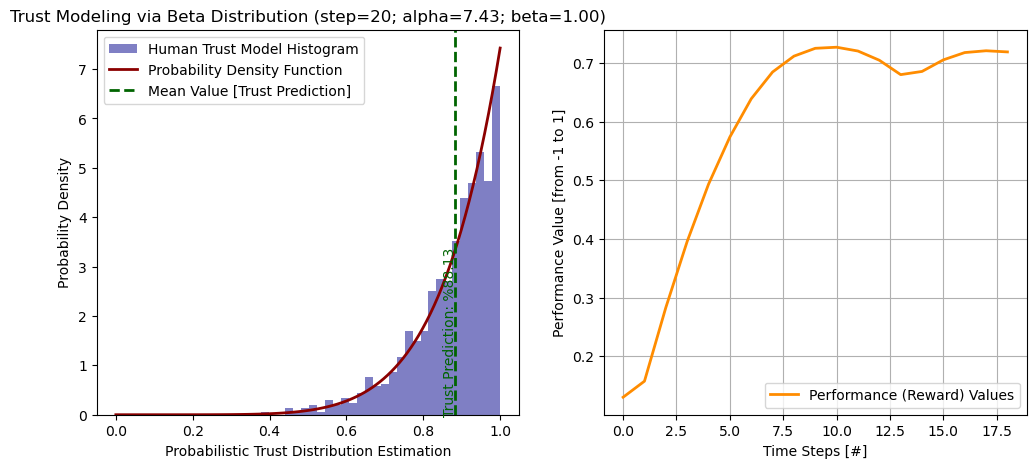

In [13]:
plot_dynamic_trust_reward(performance_array_list=reward_array_list,
                          trust_obj=trust_obj)

## Load Dummy (Not Optimized) Policy and Visualize Trust Estimations

In [14]:
dummy_policy_network = RobotPolicy(state_size=configs.state_size,
                                   hidden_size=configs.hidden_size,
                                   out_size=configs.action_size,
                                   log_std_min=configs.policy_log_std_min,
                                   log_std_max=configs.policy_log_std_max,
                                   device=configs.device)

In [15]:
unlearned_robot_trajectory = [functions.generate_session(env=env,
                                                         t_max=constants.TRAJECTORY_SIZE,
                                                         updater_obj=updater_obj,
                                                         replay_buffer=replay_buffer,
                                                         policy_network=dummy_policy_network,
                                                         is_policy_inference=True,
                                                         is_policy_gradient_update=False,
                                                         is_deterministic=True) for _ in range(episodes_to_run)][0]

dummy_state_array_list = np.array([state.numpy() for state in unlearned_robot_trajectory[0]])
dummy_action_array_list = np.array([action.numpy() for action in unlearned_robot_trajectory[1]])
dummy_reward_array_list = np.array([reward.item() for reward in unlearned_robot_trajectory[3]])

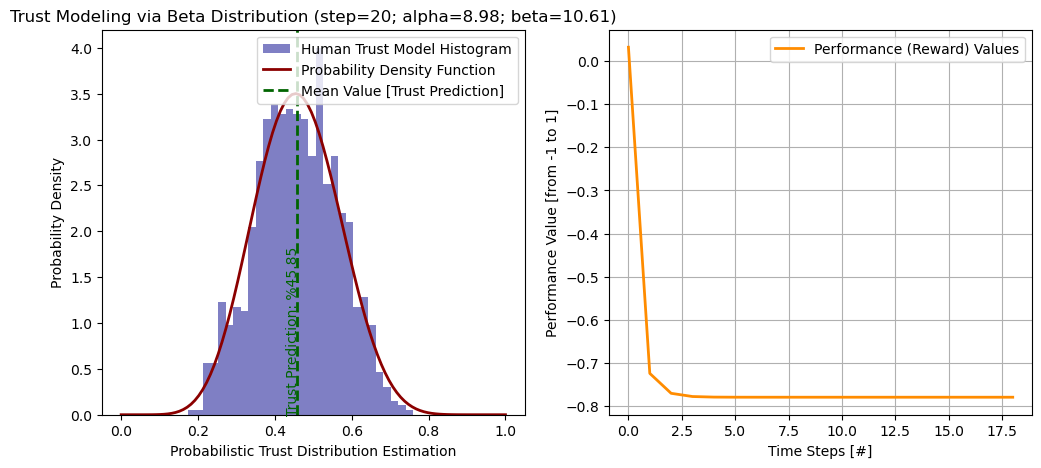

In [16]:
plot_dynamic_trust_reward(performance_array_list=dummy_reward_array_list,
                          trust_obj=trust_obj)

## Reset Trust Behavior Prediction Model

In [17]:
trust_obj = TrustDistribution(initial_alpha=configs.initial_alpha,
                              initial_beta=configs.initial_beta,
                              gamma=configs.gamma,
                              initial_w_success=configs.initial_w_success,
                              initial_w_failure=configs.initial_w_failure)

## Load Early Stages of Training Policy

In [18]:
early_policy_network = RobotPolicy(state_size=configs.state_size,
                                   hidden_size=configs.hidden_size,
                                   out_size=configs.action_size,
                                   log_std_min=configs.policy_log_std_min,
                                   log_std_max=configs.policy_log_std_max,
                                   device=configs.device)

# load pretrained policy network parameters if the pre-trained model is available (early stages of the training)
early_policy_network = functions.load_policy_from_path(policy_network=early_policy_network,
                                                       results_path=results_path,
                                                       policy_loading_folder_name="Feb_21_2024-22_47_07",
                                                       policy_params_name="policy_network_epoch_21_loss_101_83953348795573.pt")

In [19]:
lesslearned_robot_trajectory = [functions.generate_session(env=env,
                                                           t_max=constants.TRAJECTORY_SIZE,
                                                           updater_obj=updater_obj,
                                                           replay_buffer=replay_buffer,
                                                           policy_network=early_policy_network,
                                                           is_policy_inference=True,
                                                           is_policy_gradient_update=False,
                                                           is_deterministic=True) for _ in range(episodes_to_run)][0]

early_state_array_list = np.array([state.numpy() for state in lesslearned_robot_trajectory[0]])
early_action_array_list = np.array([action.numpy() for action in lesslearned_robot_trajectory[1]])
early_reward_array_list = np.array([reward.item() for reward in lesslearned_robot_trajectory[3]])

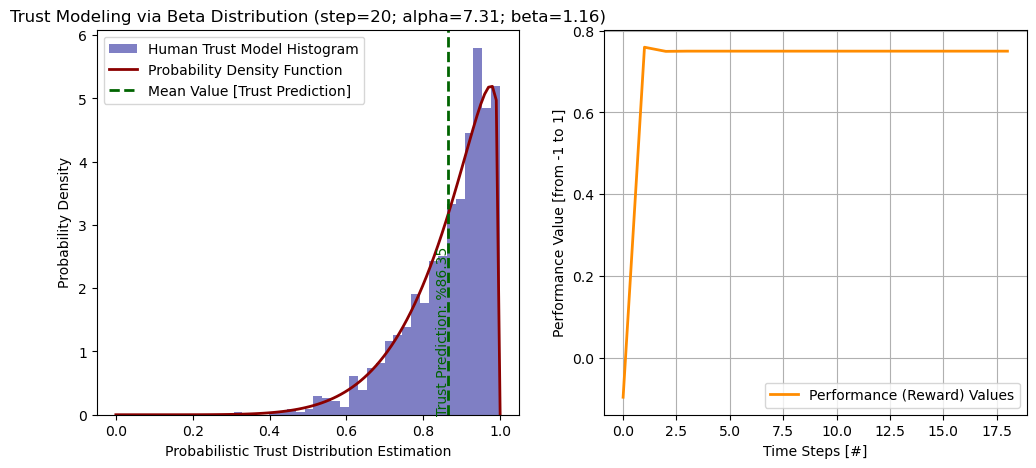

In [20]:
plot_dynamic_trust_reward(performance_array_list=early_reward_array_list,
                          trust_obj=trust_obj)